In [1]:
import os

os.chdir('/home/adeel/world-bank-rai-toolkit/')
os.path.realpath(os.curdir)

'/home/adeel/world-bank-rai-toolkit'

In [2]:
# Calculate RAI for Guatemala
import numpy as np
import rasterio
import rasterio.mask
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from shapely.ops import unary_union
import shapely.wkt

/home/adeel/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
from rai.utils import GEOD

In [4]:
def show_me(imgLr, imgRr):
    f = plt.figure(figsize=(16, 8))
    f.add_subplot(1, 2, 1)
    plt.imshow(imgLr)
    plt.axis('off')
    f.add_subplot(1, 2, 2)
    plt.imshow(imgRr)
    plt.axis('off')
    plt.show(block=True)


In [5]:
def geolen(line):
    return GEOD.geometry_length(line) / 1e3

In [6]:
def geom_len(gdf):
    return sum(map(geolen, gdf.to_crs(epsg=4326).geometry.unary_union))

In [7]:
# pfix = "py"
# code = "PRY"
# cname = "paraguay"
# utm_epsg = 32721  # for PRY
# iri_col = 'roughness'

pfix = "gt"
code = "GTM"
cname = "guatemala"
utm_epsg = 32615  # for GTM
iri_col = 'iri'

# pfix = "zm"
# code = "ZMB"
# cname = "zambia"
# utm_epsg = 20934  # for PRY
# iri_col = 'roughness'

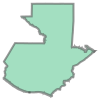

In [8]:
# Load GADM
gadm = gpd.read_file(
    f"data/inputs/gadm36_{code}.gpkg", layer=f'gadm36_{code}_0')
border = gadm['geometry'][0]
border

<AxesSubplot:>

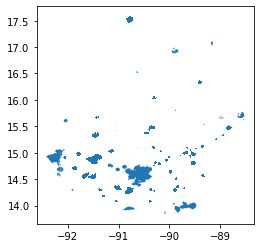

In [9]:
# Load GRUMP
grump_df = gpd.read_file(("data/inputs/grump-v1-urban-ext-polygons-rev02-shp/"
                          "global_urban_extent_polygons_v1.01.shp"))

# Filter Grump to urban areas intersecting GTM
grump_df = grump_df[grump_df.intersects(border)]
grump = list(grump_df['geometry'])
grump_df.plot()

In [10]:
# Load WorldPop dataset
worldpop = rasterio.open(f"data/inputs/{code.lower()}_ppp_2020.tif")
worldpop_img = worldpop.read(1)

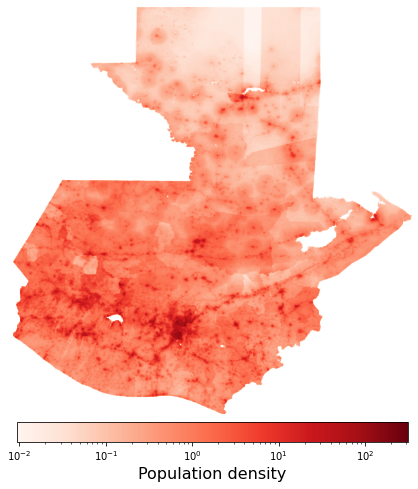

In [11]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(worldpop_img.clip(min=0), norm=colors.LogNorm(), cmap='Reds')
plt.colorbar(fraction=0.045, pad=0.02, orientation='horizontal')
cax = fig.axes[1]
cax.set_xlabel('Population density', fontsize=16)
plt.axis('off')
plt.show()

In [12]:
vmax = worldpop_img.max()

In [13]:
# Mask WorldPop by GRUMP
rural_pop_img, out_transform = rasterio.mask.mask(
    worldpop, grump, crop=False, invert=True)
rural_pop_img = rural_pop_img[0, :, :]

# with rasterio.Env():
#     with rasterio.open(f'data/{code}/{code}_worldpop_rural.tif', 'w',
#                        **worldpop.profile) as dst:
#         dst.write(rural_pop_img, 1)

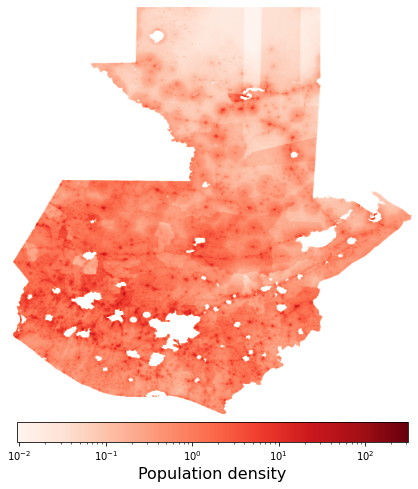

In [14]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(rural_pop_img.clip(min=0), norm=colors.LogNorm(vmax=vmax), cmap='Reds')
plt.colorbar(fraction=0.045, pad=0.02, orientation='horizontal')
cax = fig.axes[1]
cax.set_xlabel('Population density', fontsize=16)
plt.axis('off')
plt.show()

In [15]:
# Load high quality roads from OSM
osm_all_df = gpd.read_file(
    f'data/inputs/{cname}-latest-free.shp/gis_osm_roads_free_1.shp')

In [16]:
osm_all_df = osm_all_df.to_crs(epsg=4326)

In [27]:
osm_all_df.groupby('fclass').agg({'geometry': lambda g: geolen(g.unary_union)}).reset_index().rename(mapper={'geometry': 'geolen'}, axis='columns').sort_values('geolen', ascending=False)

,fclass,geolen
10,residential,23735.885996
25,unclassified,21637.847513
17,track,11013.724923
15,tertiary,8969.819975
11,secondary,3283.774149
23,trunk,2538.942814
8,primary,2328.037666
6,path,1314.774039
13,service,1260.475188
2,footway,223.884703


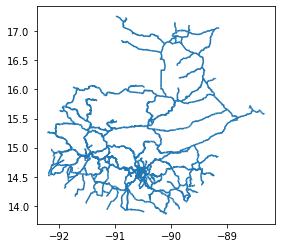

In [17]:
# Filter OSM roads to only primary and secondary, assume those are all
# weather
# osm_df = osm_df[osm_df['fclass'].isin(['primary', 'secondary'])]
osm_df = osm_all_df[osm_all_df['fclass'].isin([
    'motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary',
    'primary_link', 'secondary', 'secondary_link'
])]
osm_df.plot()

osm_w_tertiary_df = osm_all_df[osm_all_df['fclass'].isin([
    'motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary',
    'primary_link', 'secondary', 'secondary_link', 'tertiary', 'tertiary_link'
])]

<AxesSubplot:>

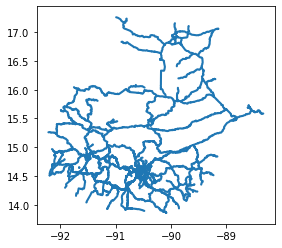

In [18]:
osm_buffers = osm_df.to_crs(epsg=utm_epsg).buffer(2000).to_crs(epsg=4326)
osm_buffers.plot()

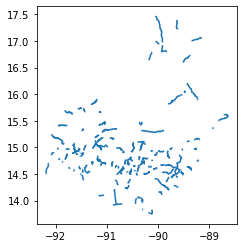

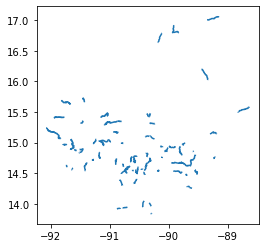

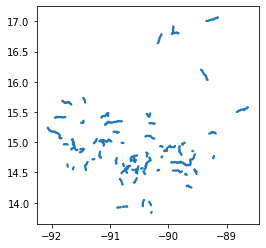

In [20]:
# Read Good matches extracted from HDM4 records
# hdm4_df = gpd.read_file(f'data/{code}/{pfix}_good_matches.gpkg').set_crs(
#     epsg=4326)
country_data_df = pd.read_csv(f'data/{code}/country_data.csv')
country_data_df.columns = map(str.lower, country_data_df.columns)
country_data_df.length = country_data_df.length.astype(float)

hdm4_df = gpd.read_file(f'data/{code}/{pfix}_good_matches.gpkg')
hdm4_df.plot()
hdm4_buffers = hdm4_df.to_crs(epsg=utm_epsg).buffer(2000).to_crs(
    epsg=4326)

# Buffer road dataframe by 2KM
fair_roads_df = hdm4_df[hdm4_df[iri_col] <= 5.0]
fair_roads_df.plot()

fair_buffers = fair_roads_df.to_crs(epsg=utm_epsg).buffer(2000).to_crs(
    epsg=4326)
fair_buffers.plot()

rough_roads_df = hdm4_df[hdm4_df[iri_col] > 5.0]
rough_buffers = rough_roads_df.to_crs(epsg=utm_epsg).buffer(2000).to_crs(
    epsg=4326)

In [21]:
country_data_df.length.sum(), country_data_df[country_data_df[iri_col] <= 5.0].length.sum()

(12671.664419785142, 6553.764425531029)

In [77]:
# matches_df = pd.read_csv(f'data/{code}/matches.csv')
# matches_df['geometry'] = matches_df['geometry'].map(shapely.wkt.loads)
# matches_df = gpd.GeoDataFrame(pd.read_csv(f'data/{code}/matches.csv'), crs='EPSG:4326', geometry=matches_df.geometry)

In [45]:
print('Total length from country data')
if pfix == 'gt':
    display(hdm4_df[['id']].merge(country_data_df, on='id', how='inner').agg({'length': 'sum'}))
elif pfix == 'py':
    display(hdm4_df[['name']].merge(country_data_df, on='name', how='inner').agg({'length': 'sum'}))

Total length from country data


length    2075.689999
dtype: float64

In [23]:
osm_all_roads = osm_w_tertiary_df.geometry.unary_union
osm_major_roads = osm_df.geometry.unary_union
cd_matched_roads = hdm4_df.geometry.unary_union
cd_good_roads = fair_roads_df.geometry.unary_union
cd_bad_roads = rough_roads_df.geometry.unary_union

matched_intersection_w_osm_major = unary_union(cd_matched_roads.intersection(osm_major_roads))
unmatched_major_roads = unary_union(osm_major_roads.difference(cd_matched_roads))

good_roads = unary_union(cd_good_roads.union(osm_major_roads))
bad_roads = unary_union(cd_bad_roads.intersection(osm_major_roads))
additional_roads = unary_union(cd_good_roads.difference(osm_major_roads))

merged_roads = unary_union(good_roads.difference(bad_roads))

print('osm_all_roads', geolen(osm_all_roads))
print('osm_major_roads', geolen(osm_major_roads))
print('cd_matched_roads', geolen(cd_matched_roads))
print('matched_intersection_w_osm_major', geolen(matched_intersection_w_osm_major))
print('unmatched_major_roads', geolen(unmatched_major_roads))
print('cd_good_roads', geolen(cd_good_roads))
print('cd_bad_roads', geolen(cd_bad_roads))
print('good_roads', geolen(good_roads))
print('additional_roads', geolen(additional_roads))
print('discarded_roads', geolen(bad_roads))
print('merged_roads', geolen(merged_roads))

osm_all_roads 17328.02723204065
osm_major_roads 8352.911425964858
cd_matched_roads 2141.860471688798
matched_intersection_w_osm_major 1184.4982794455557
unmatched_major_roads 7168.413146519317
cd_good_roads 1059.4328380725435
cd_bad_roads 1085.8057317139069
good_roads 8711.561282591258
additional_roads 358.649856626421
discarded_roads 486.5117814952296
merged_roads 8225.049501096035


In [24]:
merged_roads_df = gpd.GeoDataFrame(geometry=list(merged_roads), crs='EPSG:4326')
merged_roads_df

,geometry
0,"LINESTRING (-88.82450 15.50207, -88.82446 15.5..."
1,"LINESTRING (-88.82446 15.50169, -88.82433 15.5..."
2,"LINESTRING (-88.82433 15.50153, -88.82419 15.5..."
3,"LINESTRING (-88.82419 15.50139, -88.82398 15.5..."
4,"LINESTRING (-88.82398 15.50126, -88.82383 15.5..."
...,...
25747,"LINESTRING (-91.09190 15.28725, -91.09216 15.2..."
25748,"LINESTRING (-91.37773 14.44287, -91.37785 14.4..."
25749,"LINESTRING (-91.41671 14.52864, -91.41638 14.5..."
25750,"LINESTRING (-89.53696 14.95342, -89.53674 14.9..."


In [25]:
merged_roads_buffer = merged_roads_df.to_crs(epsg=utm_epsg).buffer(2000).to_crs(epsg=4326)

In [26]:
# Mask WorldPop by roads
# buffers = unary_union(osm_buffers.geometry.to_list() + grump)
# buffers = unary_union(fair_buffers.geometry.to_list() + osm_buffers.geometry.to_list() + grump)
buffers = unary_union(merged_roads_buffer.geometry.to_list() + grump)

unserved_pop_img, _ = rasterio.mask.mask(
    worldpop, buffers, crop=False, invert=True)
unserved_pop_img = unserved_pop_img[0]

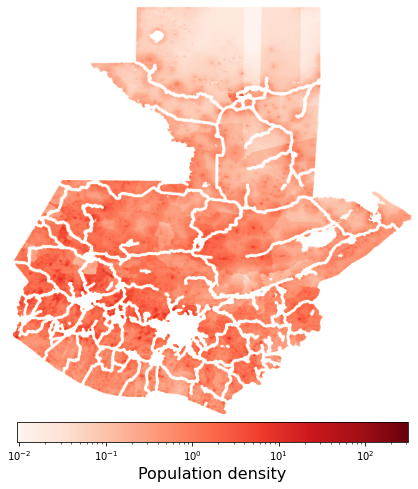

In [27]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(unserved_pop_img.clip(min=0), norm=colors.LogNorm(vmax=vmax), cmap='Reds')
plt.colorbar(fraction=0.045, pad=0.02, orientation='horizontal')
cax = fig.axes[1]
cax.set_xlabel('Population density', fontsize=16)
plt.axis('off')
plt.show()

In [124]:
with rasterio.Env():
    with rasterio.open(f'data/{code}/{code}_worldpop_rai.tif', 'w', **worldpop.profile) as dst:
        dst.write(unserved_pop_img, 1)

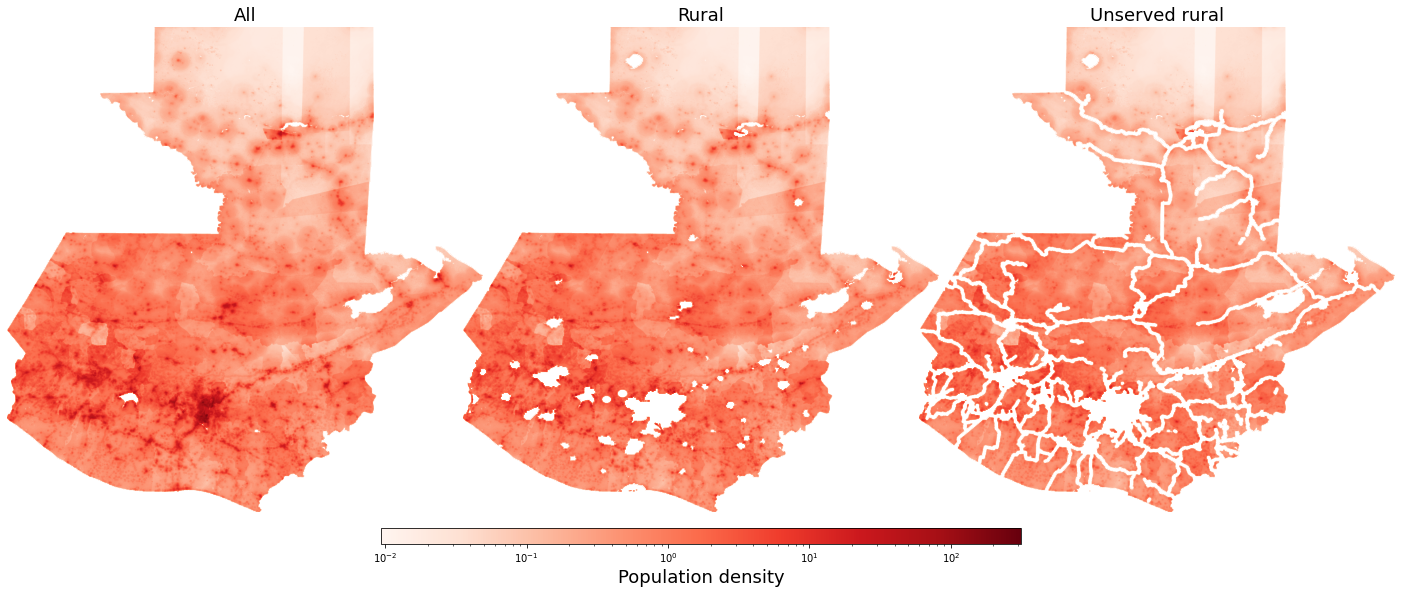

In [28]:
vmax = worldpop_img.max()

fig, axes = plt.subplots(figsize=(20, 8), nrows=1, ncols=3)
# gt
fig.tight_layout(w_pad=-5)
# py
# fig.tight_layout(w_pad=-10)

for ax, arr, title in zip(axes.flat, [worldpop_img, rural_pop_img, unserved_pop_img], ['All', 'Rural', 'Unserved rural']):
    im = ax.imshow(arr.clip(min=0), norm=colors.LogNorm(vmax=vmax), cmap='Reds')
    ax.set_title(title, fontdict={'fontsize': 18})
    ax.axis('off')

fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.03, pad=0.03, orientation='horizontal', aspect=40)
cax = fig.axes[-1]
cax.set_xlabel('Population density', fontsize=18)
plt.show()

In [127]:
fig.savefig(f'{pfix}_pop_map.png', bbox_inches='tight', pad_inches=0.)

In [29]:
# RAI
def calc_rai(rural_pop_img, unserved_pop_img):
    rural_pop = rural_pop_img[rural_pop_img >= 0].sum()
    unserved_pop = unserved_pop_img[unserved_pop_img >= 0].sum()
    rai = (rural_pop - unserved_pop) / rural_pop
    out = {
        'rural_pop': round(rural_pop),
        'unserved_pop': round(unserved_pop),
        'served_pop': round(rural_pop - unserved_pop),
        'rai': round(100 * rai, 2)
    }
    return out

In [30]:
print('OSM + matched')
calc_rai(rural_pop_img, unserved_pop_img)

OSM + matched


{'rural_pop': 11658611,
 'unserved_pop': 7097136,
 'served_pop': 4561476,
 'rai': 39.13}

In [31]:
_osm_buffers_df = gpd.GeoDataFrame(geometry=[osm_buffers.geometry.unary_union])
_rough_buffers_df = gpd.GeoDataFrame(geometry=[rough_buffers.geometry.unary_union])
_fair_buffers_df = gpd.GeoDataFrame(geometry=[fair_buffers.geometry.unary_union])

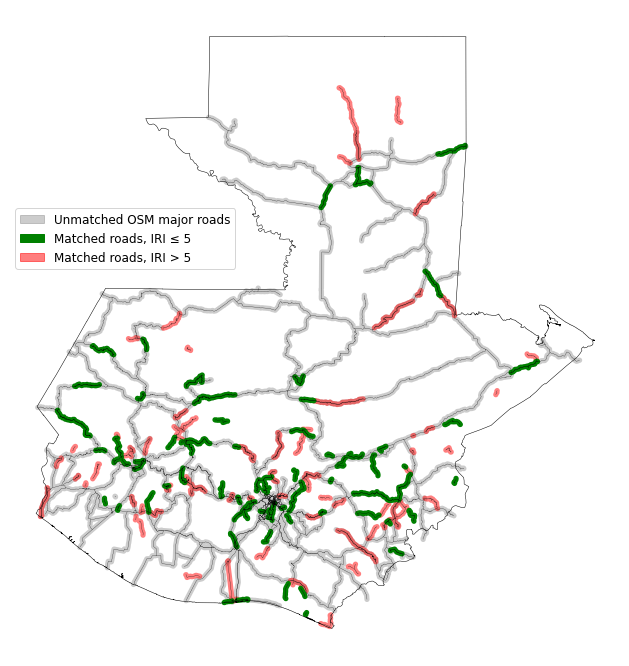

In [36]:
fig = plt.figure(figsize=(12, 12))
if pfix == 'gt':
    bx, by = border.boundary[-1].xy
elif pfix == 'py':
    bx, by = border.boundary.xy
plt.plot(bx, by, color='black', linewidth=0.5)
ax = plt.gca()
_osm_buffers_df.plot(ax=ax, color='gray', alpha=.4, label='OSM major roads')
_rough_buffers_df.plot(ax=ax, color='red', alpha=.5, label='Matched roads w/ IRI > 5')
_fair_buffers_df.plot(ax=ax, color='green', alpha=1, label='Matched roads w/ IRI <= 5')
osm_df.plot(ax=ax, linewidth=.25, color='black')
fair_roads_df.plot(ax=ax, linewidth=.25, color='black')
rough_roads_df.plot(ax=ax, linewidth=.25, color='black')

legend_patches = [
    patches.Patch(color='gray', alpha=.4, label='Unmatched OSM major roads'),
    patches.Patch(color='green', alpha=1, label='Matched roads, IRI ≤ 5'),
    patches.Patch(color='red', alpha=.5, label='Matched roads, IRI > 5'),
]
if pfix == 'py':
    plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(.99, .79), fontsize=12)
elif pfix == 'gt':
    plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(.38, .7), fontsize=12)

plt.axis('off')
plt.show()

In [37]:
fig.savefig(f'{pfix}_road_map.png', bbox_inches='tight', pad_inches=0)